In [1]:
import os

from syntax_sugar import END, pipe
from syntax_sugar import process_syntax as p
from syntax_sugar import thread_syntax as t
NTHR = 16
import os
from os.path import join

In [2]:
import h5py

In [3]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM
from QuarkTM import Channel, ChannelGroup, ChannelL, Particle

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6

qrange = linspace(0, 5, 101)
erange = linspace(-5, 5, 401)
eps = 10e-2
# pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)

G = 5
L = 0.5
screen = 0.02
G1 = 4

# ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

params = {'G' : G, 'L' : L, 'screen' : screen}
params_rep = {'G' : -G, 'L' : L, 'screen' : screen}
params1 = {'G' : G1, 'L' : L, 'screen' : screen}
params_rep1 = {'G' : -G1, 'L' : L, 'screen' : screen}


pss = [params, params1]
pss_rep = [params_rep, params_rep1]
mu = 0
lmax = 1

In [169]:
T = 0.25

In [170]:
import warnings
warnings.filterwarnings('ignore')

In [171]:
def f(x, T):
    return 1/(exp(x/T) + 1)

Start of iterations

In [172]:
subtr = 1

In [173]:
folder = '8ch_noscreen_trange'
if subtr:
    folder += '_subtr'

if not os.path.exists(folder):
    os.mkdir(folder)

In [174]:
quark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)
aquark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)

In [175]:
imss = array([array([-eps for q in qrange])]*2).transpose()
ress = array([array([0. for q in qrange])]*2).transpose()

In [176]:
eArr = array([erange for q in qrange]).transpose()

In [177]:
omKs = array([sqrt(mQ**2 + qrange**2)]*2).transpose()

In [178]:
mu = 0*T

In [179]:
DELTA = 1

In [180]:
Trange = linspace(0.15, 0.55, 21)

In [181]:
Trange[:10:2]

array([0.15, 0.19, 0.23, 0.27, 0.31])

In [182]:
Trange

array([0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35,
       0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55])

In [183]:
Trange = array([0.4])

In [184]:
folder = 'iterations_04'

In [185]:
for T in Trange:
    DELTA = 1
    print('Processing T = ', T)
    iter = 0
    omKs_iter = []
    ress_iter = []
    imss_iter = []
    G2ss_iter = []
    chs_iter = []
    TMss_iter = []
    Xss_iter = []
    
    while DELTA > 1e-4:
        channels_QQ = QuarkTM.ChannelGroup(mu0=False)
        
        ImS_K_Arrs = [array([ims for e in erange]) for ims in imss.transpose()]
        ReS_K_Arrs = [array([res for e in erange]) for res in ress.transpose()]
        
        omArrs = [array([omk for e in erange]) for omk in omKs.transpose()]
        
        G2_QQ = (1 - 2*f(omArrs[0], T)) / (eArr - 2*omArrs[0] - 1j*2*ImS_K_Arrs[0] + 2*mu)
        
        channels_QQ.addChannel(
            QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
        )
    
        channels_QQ.addChannel(
            QuarkTM.ChannelL('qq6', lmax, quark_run, quark_run, T, pss_rep, ds=4, da=6, Fa=1/4, mu=mu, G2=G2_QQ)
        )
    
        channels_QQ.addChannel(
            QuarkTM.ChannelL('qa8', lmax, quark_run, aquark_run, T, pss_rep, ds=4, da=8, Fa=1/8, mu=mu, G2=G2_QQ)
        )
        
        channels_QQ.addChannel(
            QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QQ)
        )
        
        # channels_AA.addChannel(
        #     QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_AA)
        # )
        
        # channels_AQ.addChannel(
        #     QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
        # )
    
        # channels_AA.addChannel(
        #     QuarkTM.ChannelL('aa6', lmax, aquark_run, aquark_run, T, pss_rep, ds=4, da=6, Fa=1/4, mu=mu, G2=G2_AA)
        # )
    
        # channels_AQ.addChannel(
        #     QuarkTM.ChannelL('aq8', lmax, aquark_run, quark_run, T, pss_rep, ds=4, da=8, Fa=1/8, mu=mu, G2=G2_QA)
        # )
        
        omKs_old = omKs.copy()    
        ################# Build the T-matrix array #########################

        TMss = []

        TM = channels_QQ.get_T()
        # for i, chs, Gs, lbl in zip(range(2), [chs_Q, chs_A], [Gs_Q, Gs_A], ['Q', 'A']):
        #     TMs = []
        #     for j, ch in enumerate(chs):
        #         TM = ch.get_T()
        #         TM[erange < 0] = real(TM[erange < 0])
        #         if subtr:
        #             TM -= (TM[0, :] + TM[1, :])/2
        #         TMs += [TM]
        #     TMss += [TMs]
        TM[erange < 0] = real(TM[erange < 0])
        if subtr:
            TM -= (TM[0, :] + TM[1, :])/2
        TMss += [TM]
        
        omKs = []
        ress = []
        imss = []

        TMss_iter += [TMss]
        
        Xss_iter += [{k: ch.chs[0].XS[0] for k, ch in channels_QQ.channels.items()}]

        
        for q in qrange:
            oms = []
            res = []
            ims = []
    
            iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))
            iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))
            iEps_i = tm.Interpolator(qrange, ascontiguousarray(omArrs[0][0, :]), 'cubic')
            iEps_j = tm.Interpolator(qrange, ascontiguousarray(omArrs[0][0, :]), 'cubic')
            re = tm.SigmaQP(iEps_i(q), q, T, iReTM, quark_run.R, iEps_i, iEps_j, 0, 0)
            im = tm.SigmaQP(iEps_i(q), q, T, iImTM, quark_run.R, iEps_i, iEps_j, 0, 0)
            om = sqrt(mQ**2 + q**2) + re
                # delta = abs(x - x0)
                # print('k = ', k, 'delta = ', delta)
                # print(om, re, im)
            oms = [om]
            ims = [im]
            res = [re]
        # print(oms)
            omKs += [oms]
            imss += [ims]
            ress += [res]

    
        
        # for k in tqdm.notebook.tqdm(qrange):
        #     xs
            
        #     omKs += [xs]
        #     ress += [res]
        #     imss += [ims]

        # omKs = OUT[:, 0]
        # imss = OUT[:, 0]
        # ress = OUT[:, 0]

        # omKs = [o[0] for o in OUT]
        # imss = [o[1] for o in OUT]
        # ress = [o[2] for o in OUT]
        
        omKs = array(omKs)
        omKs_old = array(omKs_old)
        imss = array(imss)
        ress = array(ress)
    
        DELTA = np.max(abs(omKs_old - omKs))
        print(DELTA, omKs[0, 0])

        omKs_iter += [omKs]
        ress_iter += [ress]
        imss_iter += [imss]

        G2ss_iter += [G2_QQ]
        chs_iter += [channels_QQ]
        
        
    
    # df = h5py.File(os.path.join(folder, 'data_T=%.3f.hdf5'%T), 'w')
    # kk = ['Q', 'Q', 'A', 'A']
    # for _k, gr in zip(kk, [channels_QQ, channels_QA, channels_AA, channels_AQ]):
    #     gr.get_T()
    #     for k, chl in gr.channels.items():
    #         for l in range(chl.lmax + 1):
    #             c = chl.chs[l]
    #             df.create_dataset(f'TM/{k}/{l}', data=c.TM)
    #             df[f'TM/{k}/{l}'].attrs.update({'v' : c.v(qrange), 'ds' : c.ds, 'da' : c.da, 'Fa' : c.Fa})
    #             df.create_dataset(f'X/{k}/{l}', data=c.XS[0])
    #             df[f'X/{k}/{l}'].attrs.update({'v' : c.v(qrange), 'ds' : c.ds, 'da' : c.da, 'Fa' : c.Fa})
    
    
    # df.attrs.update({'qrange' : qrange})
    # df.create_dataset(f'S/Q', data=ress[:,0] + 1j*imss[:, 0])
    # df.create_dataset(f'S/A', data=ress[:,1] + 1j*imss[:, 1])
    # df.create_dataset(f'/Eps/Q', data=omKs[:, 0])
    # df.create_dataset(f'/Eps/A', data=omKs[:, 1])
    # df.create_dataset(f'/G2/QA', data=G2_QA)
    # df.create_dataset(f'/G2/QQ', data=G2_QQ)
    # df.create_dataset(f'/G2/AA', data=G2_AA)
    
    # df.close()

Processing T =  0.4
0.03482932997161259 0.5651706700283874
0.015451203239865041 0.5593387451782166
0.090115215013159 0.4692235301650576
0.032154684574968895 0.501071034260654
0.053093239670688464 0.44797779458996556
0.01660281596482882 0.4593451804251618
0.028016688920955657 0.43132849150420616
0.00970855893363154 0.4316669676288847
0.016459838965882434 0.41520712866300225
0.008186301263315543 0.41108007032013283
0.011613057728446341 0.3994670125916865
0.009356468534576723 0.39321552501357954
0.010126871481895672 0.38308865353168386
0.012129911954314232 0.3749173253735724
0.013218803149302683 0.3639096007946656
0.015083561947937585 0.3525398069419981
0.018483891136331365 0.33766529579722326
0.023397672442617423 0.3194933636657715
0.02510683912832523 0.2943865245374463
0.03566661076156713 0.25871991377587916
0.0562838597028803 0.20243605407299886
0.09851773575523876 0.1039183183177601
0.2010893444263684 -0.09717102610860828
0.3078764140659279 -0.4050474401745362
1.0050474401745362 0.6


KeyboardInterrupt: 

## Inspect iterations

In [186]:
# iters = [0, 1, 2, 3, 4][::1]
# iters = [7, 8, 9, 10, 11]
# iters = [15, 16, 17, 18]
iters = [19, 20, 21, 22]
# iters = [12, 13, 14]
# iters = [-1]

In [187]:
lss = ['-', '--', '-.', ':']*3

In [188]:
suff = ''.join(['%i'%i for i in iters])
suff

'19202122'

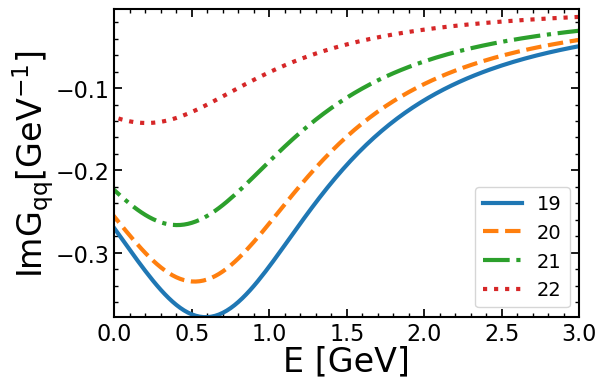

In [189]:
for i, ls in zip(iters, lss):
    l_i, = plt.plot(erange, imag(G2ss_iter[i][:, 0]), label='%i'%i, ls=ls)
    # l_r, = plt.plot(erange, real(G2ss_iter[i][:, 0]), label='%i'%i, ls=ls, lw=1.5, c=l_i.get_c())

    # l_i = plt.plot(qrange, imss_iter[i][:, 0], ls=':', c=l_r.get_c())

plt.legend(fontsize=14)

plt.ylabel(r'$Im G_{qq} [GeV^{-1}$]')

plt.xlabel('E [GeV]')
plt.xlim(0, 3)

plt.savefig(f'{folder}/G2_' + suff + '.pdf', bbox_inches='tight')

In [190]:
i_15 = argmin(abs(erange - 1.5))
i_15

260

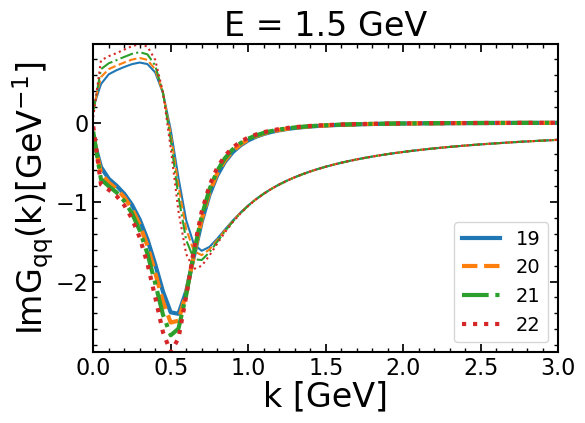

In [191]:
for i, ls in zip(iters, lss):
    l_i, = plt.plot(qrange, imag(G2ss_iter[i][i_15, :]), label='%i'%i, ls=ls)
    l_r, = plt.plot(qrange, real(G2ss_iter[i][i_15, :]), ls=ls, lw=1.5, c=l_i.get_c())

    # l_i = plt.plot(qrange, imss_iter[i][:, 0], ls=':', c=l_r.get_c())

plt.legend(fontsize=14)

plt.ylabel(r'$Im G_{qq} (k) [GeV^{-1}$]')

plt.xlabel('k [GeV]')
plt.xlim(0, 3)
plt.title('E = 1.5 GeV')
plt.savefig(f'{folder}/G2_K_' + suff + '.pdf', bbox_inches='tight')

In [195]:
sqrt(0.01 * (400/150)**2)

0.26666666666666666

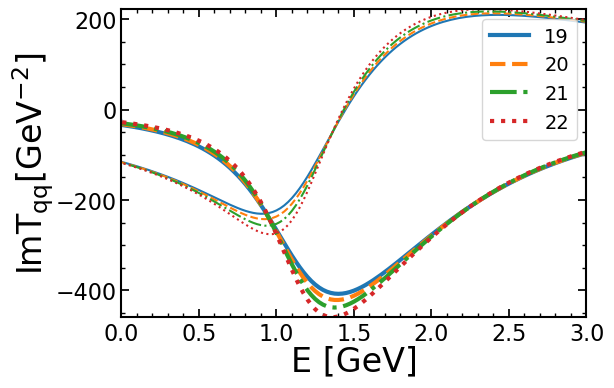

In [193]:
for i, ls in zip(iters, lss):
    li, = plt.plot(erange, imag(TMss_iter[i][0][:, 0]), ls=ls, label='%i'%i)
    plt.plot(erange, real(TMss_iter[i][0][:, 0]), ls=ls, c=li.get_c(), lw=1.5)


plt.xlim(0, 3)
plt.legend(fontsize=14)


plt.ylabel(r'$Im T_{qq} [GeV^{-2}$]')

plt.xlabel('E [GeV]')
plt.xlim(0, 3)

plt.savefig(f'{folder}/TM_' + suff + '.pdf', bbox_inches='tight')

(0.0, 3.0)

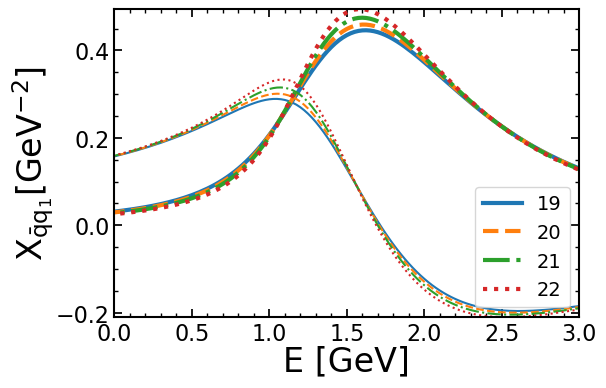

In [120]:
for i, ls in zip(iters, lss):
    li, = plt.plot(erange, imag(Xss_iter[i]['qa1'][:, 0]), ls=ls, label='%i'%i)
    plt.plot(erange, real(Xss_iter[i]['qa1'][:, 0]), ls=ls, c=li.get_c(), lw=1.5)
    # plt.plot(erange, real(TMss_iter[i][0][:, 0]), ls=ls, c=li.get_c(), lw=1.5)


plt.xlim(0, 3)
plt.legend(fontsize=14)


plt.ylabel(r'$X_{\bar qq_1} [GeV^{-2}$]')

plt.xlabel('E [GeV]')
plt.xlim(0, 3)

# plt.savefig('iterations_04/TM_' + suff + '.pdf', bbox_inches='tight')

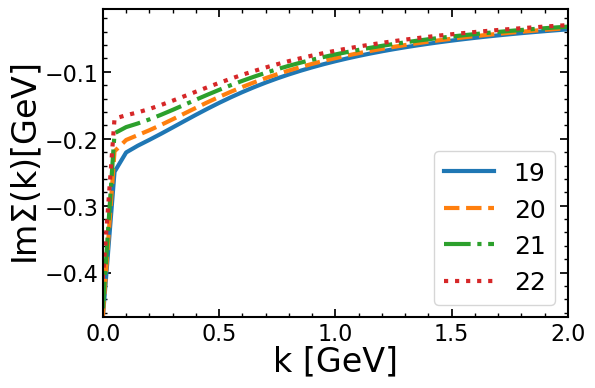

In [121]:
for i, ls in zip(iters, lss):
    l_r, = plt.plot(qrange, imss_iter[i][:, 0], label='%i'%i, ls=ls)
    # l_i = plt.plot(qrange, imss_iter[i][:, 0], ls=':', c=l_r.get_c())

plt.legend()

plt.ylabel(r'$Im\Sigma(k) [GeV$]')

plt.xlabel('k [GeV]')
plt.xlim(0, 2)

plt.savefig(f'{folder}/ImS_' + suff + '.pdf', bbox_inches='tight')


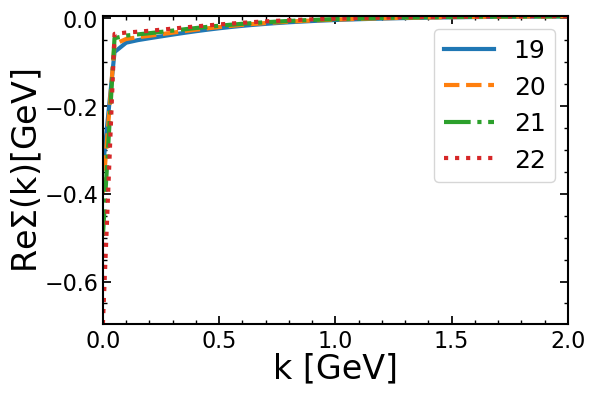

In [122]:
for i, ls in zip(iters, lss):
    l_r, = plt.plot(qrange, ress_iter[i][:, 0], label='%i'%i, ls=ls)
    # l_i = plt.plot(qrange, imss_iter[i][:, 0], ls=':', c=l_r.get_c())

plt.legend()

plt.ylabel(r'$Re\Sigma(k) [GeV$]')

plt.xlabel('k [GeV]')
plt.xlim(0, 2)

plt.savefig(f'{folder}/ReS_' + suff + '.pdf', bbox_inches='tight')

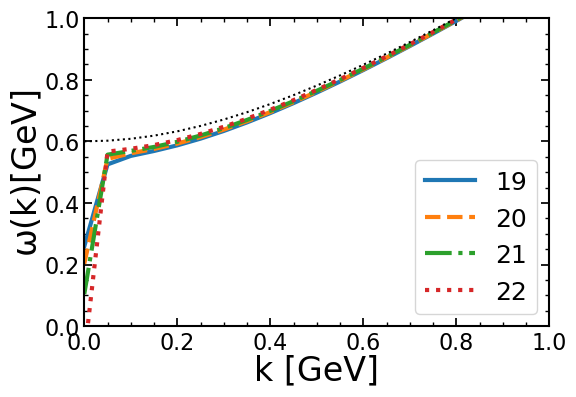

In [123]:
for i, ls in zip(iters, lss):
    l_r, = plt.plot(qrange, omKs_iter[i][:, 0], label='%i'%i, ls=ls)
    # l_i = plt.plot(qrange, imss_iter[i][:, 0], ls=':', c=l_r.get_c())

plt.legend()

plt.ylabel(r'$\omega(k) [GeV$]')

plt.plot(qrange, sqrt(mQ**2 + qrange**2), ls=':', c='black', lw=1.5)

plt.xlabel('k [GeV]')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.savefig(f'{folder}/omK_' + suff + '.pdf', bbox_inches='tight')

## Compare values

## Misc

In [124]:
plt.plot(qrange, omKs[:, 0])
plt.plot(qrange, sqrt(mQ**2 + qrange**2), ls='--')

TypeError: list indices must be integers or slices, not tuple

In [ ]:
plt.plot(qrange, ress[:, 0])
plt.plot(qrange, imss[:, 0])

In [81]:
df.close()

NameError: name 'df' is not defined

In [166]:
__ = channels_QQ.get_T()

In [198]:
channels_QA['qa1'].chs[0].TM

AttributeError: 'Channel' object has no attribute 'TM'

In [171]:
channels_QQ['qq3'].chs[1].XS

[array([[ 0.01086167+7.38442635e-05j,  0.01086167+7.38442635e-05j,
          0.01086167+7.38442635e-05j, ...,  0.01086167+7.38442635e-05j,
          0.01086167+7.38442635e-05j,  0.01086167+7.38442635e-05j],
        [ 0.01093981+7.49591713e-05j,  0.01093981+7.49591713e-05j,
          0.01093981+7.49591713e-05j, ...,  0.01093981+7.49591713e-05j,
          0.01093981+7.49591713e-05j,  0.01093981+7.49591713e-05j],
        [ 0.01101909+7.60996023e-05j,  0.01101909+7.60996023e-05j,
          0.01101909+7.60996023e-05j, ...,  0.01101909+7.60996023e-05j,
          0.01101909+7.60996023e-05j,  0.01101909+7.60996023e-05j],
        ...,
        [-0.02388578+1.05375777e-03j, -0.02388578+1.05375777e-03j,
         -0.02388578+1.05375777e-03j, ..., -0.02388578+1.05375777e-03j,
         -0.02388578+1.05375777e-03j, -0.02388578+1.05375777e-03j],
        [-0.02417729+6.12164352e-02j, -0.02417729+6.12164352e-02j,
         -0.02417729+6.12164352e-02j, ..., -0.02417729+6.12164352e-02j,
         -0.02417729

In [145]:
get_xs(0.5)

([0.7838913525076949, 0.7838913525076949],
 0.0028663849170295352,
 -0.024985880074876093)

In [144]:
OUT

[([0.6025900959492952, 0.6025900959492952],
  0.0025900959492953088,
  -0.03864067667713826),
 ([0.6108928610053742, 0.6108928610053742],
  0.002616607975552297,
  -0.03787862660005953),
 ([0.6351390728942041, 0.6351390728942041],
  0.002683540860528276,
  -0.03577265477068179),
 ([0.6735828669580936, 0.6735828669580936],
  0.002762473708156587,
  -0.032748188023287945),
 ([0.7239348796933783, 0.7239348796933783],
  0.002824624600580432,
  -0.029288842354522292),
 ([0.7838767782282257, 0.7838767782282257],
  0.002851810637560206,
  -0.025779899050599978),
 ([0.8513662144254537, 0.8513662144254537],
  0.002838077001596541,
  -0.02246453320023873),
 ([0.9247406009668706, 0.9247406009668706],
  0.0027861552375818177,
  -0.01946486593947097),
 ([1.0027031348404065, 1.0027031348404065],
  0.0027031348404064764,
  -0.016822020951578424),
 ([1.084262707059762, 1.084262707059762],
  0.0025973244205653523,
  -0.014530762671229608),
 ([1.168666882698235, 1.168666882698235],
  0.00247650372917497

In [143]:
imss.shape

(51,)

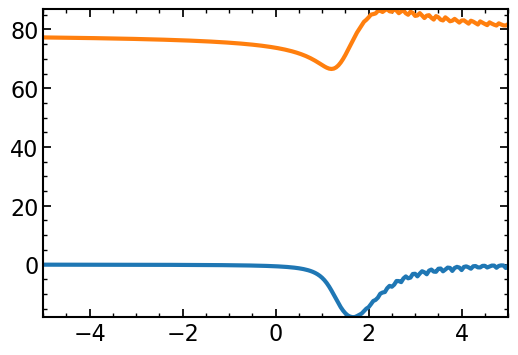

In [27]:
plt.plot(erange, imag(channels_QQ['qq6'].chs[0].TM)[:, 0])
plt.plot(erange, real(channels_QQ['qq6'].chs[0].TM)[:, 0])

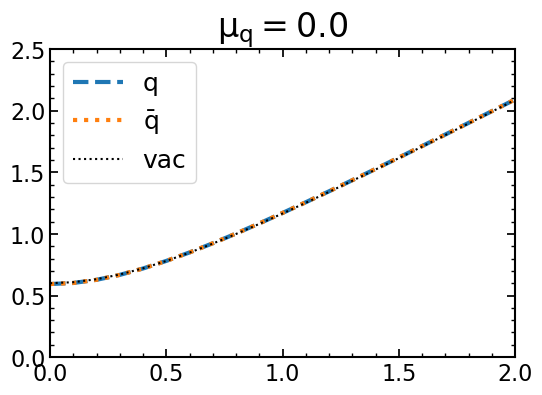

In [28]:
lQ, = plt.plot(qrange, omKs[:, 0], ls='--', label='q')
lA, = plt.plot(qrange, omKs[:, 1], ls=':', label=r'$\bar q$')
plt.plot(qrange, sqrt(mQ**2 + qrange**2), ls=':', lw=1.5, c='black', label='vac')

plt.legend()

plt.xlim(0, 2)
plt.ylim(0, 2.5)
plt.title(fr'$\mu_q = {mu/T}$')

suff = ''
if subtr:
    suff = '_subtr'

# plt.savefig('omk_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')

Text(0.5, 0, 'k [GeV]')

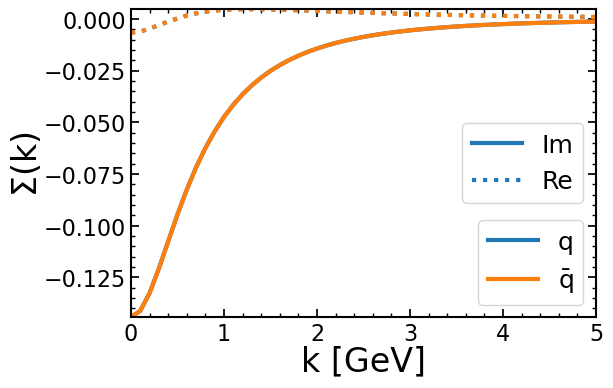

In [29]:
lQ, = plt.plot(qrange, imss[:, 0], ls='-')
lQre, = plt.plot(qrange, ress[:, 0], ls=':', c=lQ.get_c())

lA, = plt.plot(qrange, imss[:, 1], ls='-')
plt.plot(qrange, ress[:, 1], ls=':', c=lA.get_c())

leg = plt.legend([lQ, lQre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lQ, lA], ['q', r'$\bar q$'])

plt.gca().add_artist(leg)

# plt.plot(qrange, sqrt(mQ**2 + qrange**2))

# plt.xlim(0, 2)
# plt.ylim(0, 2.5)
plt.ylabel(r'$\Sigma(k)$')
plt.xlabel('k [GeV]')

# plt.savefig('Sk_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


(0.0, 3.0)

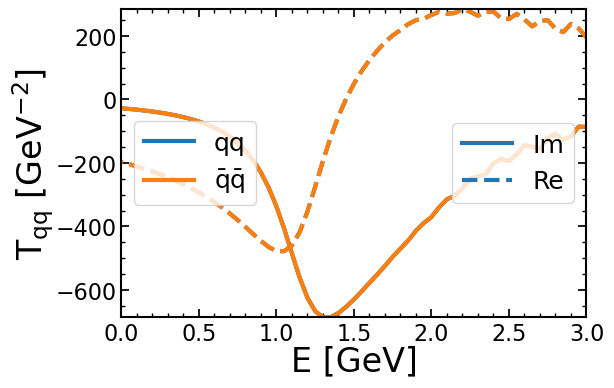

In [30]:
lq, = plt.plot(erange, imag(channels_QQ.get_T())[:, 0], label='qq')
la, = plt.plot(erange, imag(channels_AA.get_T())[:, 0], label='\bar q q')

lqre, = plt.plot(erange, real(channels_QQ.get_T())[:, 0], c=lq.get_c(), ls='--')
plt.plot(erange, real(channels_AA.get_T())[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$T_{qq}$ [GeV$^{-2}$]')
plt.xlabel(r'E [GeV]')

leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='center left')
plt.gca().add_artist(leg)

plt.xlim(0, 3)

# plt.savefig('T_qq_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


(0.0, 3.0)

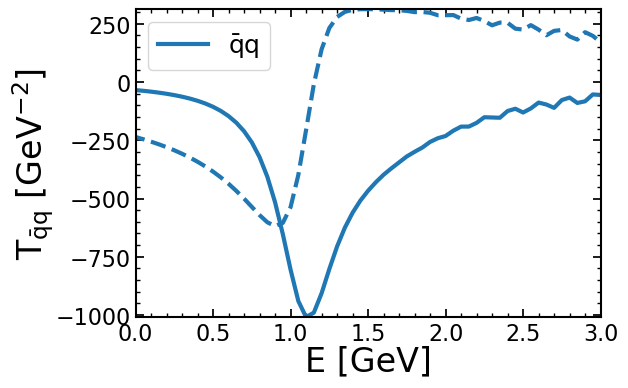

In [32]:
plt.plot(erange, imag(channels_QA.get_T())[:, 0], label=r'$\bar qq$')
# la, = plt.plot(erange, imag(channels_AA.get_T())[:, 0], label='\bar q q')

plt.plot(erange, real(channels_QA.get_T())[:, 0], c=lq.get_c(), ls='--')
# plt.plot(erange, real(channels_AA.get_T())[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$T_{\bar qq}$ [GeV$^{-2}$]')
plt.xlabel(r'E [GeV]')

# leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

# leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='center left')
plt.legend()
# plt.gca().add_artist(leg)

plt.xlim(0, 3)
# plt.savefig('T_qa_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')


(0.0, 3.0)

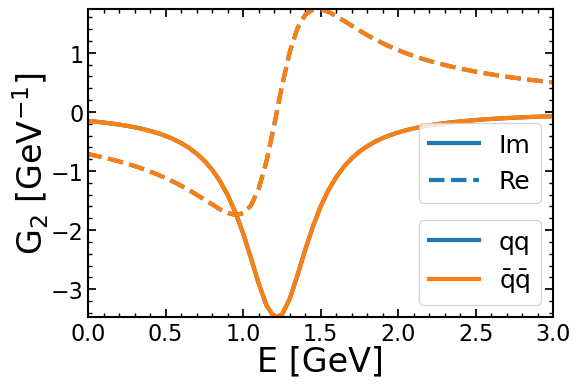

In [33]:
lq, = plt.plot(erange, imag(G2_QQ)[:, 0], label='qq')
la, = plt.plot(erange, imag(G2_AA)[:, 0], label='\bar q q')

lqre, = plt.plot(erange, real(G2_QQ)[:, 0], c=lq.get_c(), ls='--')
plt.plot(erange, real(G2_AA)[:, 0], c=la.get_c(), ls='--')

plt.ylabel(r'$G_{2}$ [GeV$^{-1}$]')
plt.xlabel(r'E [GeV]')

leg = plt.legend([lq, lqre], ['Im', 'Re'], loc='center right')

leg2 = plt.legend([lq, la], ['qq', r'$\bar q \bar q$'], loc='lower right')
plt.gca().add_artist(leg)

plt.xlim(0, 3)

# plt.savefig('G2_qq_T=%.2f_mu=%.2f%s.pdf'%(T, mu/T, suff), bbox_inches='tight')
